In [29]:
# ===============================================
# STEP 0 — Imports, config, and speed knobs
# ===============================================
import warnings, time, numpy as np, pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline as SkPipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix,
    classification_report, precision_recall_curve
)
import joblib

# ---- paths / label (EDIT as needed) ----
CSV_PATH     = "../data/processed/11_biz_merged_clean.csv"
PKL_PATH    = "../data/processed/14_processed_df.pkl"


TARGET_COL   = "avg_stars_2019"
POSITIVE_MIN = 4  # binarize: >= 4 stars => 1

# ---- speed knobs ----
CV_FOLDS             = 5
EN_N_ITER            = 12
RF_N_ITER            = 16
SUBSAMPLE_FOR_TUNING = None   # e.g. 25000 to tune on subset, then refit on full; or None
OHE_MIN_FREQ         = 20     # merge rare levels to reduce feature count
SEARCH_N_JOBS        = -1
VERBOSE              = 2

warnings.filterwarnings("ignore", message="Skipping features without any observed values")

In [30]:
# ===============================================
# STEP 1 — Load data
# ===============================================
df = pd.read_csv(CSV_PATH)
print("Loaded:", df.shape)

Loaded: (36261, 61)


In [31]:
# Load the *fitted* ColumnTransformer you saved earlier
preprocessor = joblib.load(PKL_PATH)

In [32]:
preprocessor

,transformers,"[('cont', ...), ('ord', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


## Coercing

In [33]:
import pandas as pd
import numpy as np

# --- 1. Convert datetime columns ---
datetime_cols = ["first_review_2019", "last_review_2019"]
for col in datetime_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce")

# --- 2. Convert boolean columns (True/False or Yes/No or t/f) ---
bool_cols = [
    "is_open", "attr_ByAppointmentOnly", "attr_BusinessAcceptsCreditCards",
    "attr_BikeParking", "attr_RestaurantsTakeOut", "attr_RestaurantsDelivery",
    "attr_Caters", "attr_WheelchairAccessible", "attr_HappyHour",
    "attr_OutdoorSeating", "attr_HasTV", "attr_RestaurantsReservations",
    "attr_DogsAllowed", "attr_GoodForKids", "attr_RestaurantsTableService",
    "attr_RestaurantsGoodForGroups", "attr_DriveThru", "has_hours_info"
]

for col in bool_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().replace(
            {"True": True, "False": False, "Yes": True, "No": False, "None": np.nan, "nan": np.nan}
        )
        df[col] = df[col].astype("boolean")

# --- 3. Convert category columns ---
category_cols = [
    "attr_RestaurantsPriceRange2", "attr_WiFi", "attr_Alcohol",
    "attr_RestaurantsAttire", "attr_NoiseLevel", "attr_Smoking"
]
for col in category_cols:
    if col in df.columns:
        df[col] = df[col].astype("category")

# --- 4. Convert small integer columns to int8 for memory efficiency ---
int8_cols = [
    "cat__Sandwiches", "cat__American (Traditional)", "cat__Pizza",
    "cat__Fast Food", "cat__Breakfast & Brunch", "cat__American (New)",
    "cat__Burgers", "cat__Mexican", "cat__Italian", "cat__Coffee & Tea",
    "cat__Seafood", "cat__Chinese", "cat__Salad", "cat__Chicken Wings",
    "cat__Cafes", "cat__Delis", "cat__Caterers", "cat__Specialty Food",
    "cat__Bakeries", "cat__Desserts"
]
for col in int8_cols:
    if col in df.columns:
        df[col] = df[col].astype("int8")

# --- 5. Convert others explicitly to float if not already ---
float_cols = [
    "latitude", "longitude", "review_count", "review_count_log1p",
    "total_weekly_hours", "days_open", "weekend_hours", "avg_daily_hours",
    "avg_stars_2019", "rl_word_mean", "rl_share_short24"
]
for col in float_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce").astype("float64")

# --- 6. Optional: compress integers like rev_count_2019 ---
df["rev_count_2019"] = df["rev_count_2019"].astype("int64")


/var/folders/l_/bfn4zmvj11j3519tmtl4xcd40000gn/T/ipykernel_72337/1128991930.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].astype(str).str.strip().replace(
/var/folders/l_/bfn4zmvj11j3519tmtl4xcd40000gn/T/ipykernel_72337/1128991930.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].astype(str).str.strip().replace(


## Define Target and Predictor

In [34]:
# Target
y = df["avg_stars_2019"].astype(float)

# Columns to exclude from predictors
exclude = {
    "business_id", "city", "state",
    "avg_stars_2019", "review_count",
    "rev_count_2019", "first_review_2019", "last_review_2019",
}

# Build X (everything except target + excluded)

feature_cols = [c for c in df.columns if c not in exclude]
X = df[feature_cols].copy()

In [35]:
# Binary classification target
y_cls = (y >= 4.0).astype(int)
y_cls.value_counts(normalize=True).round(3)  # quick class balance check

avg_stars_2019
0    0.614
1    0.386
Name: proportion, dtype: float64

## Split X train and y train

In [36]:
# Sklearn imports for optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Partition predictors & response into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cls,
    test_size = 0.2,   # Reserve 20% for "hold-out" data, 
    random_state=42
)

X_train.head(5)

,latitude,longitude,is_open,review_count_log1p,attr_ByAppointmentOnly,attr_BusinessAcceptsCreditCards,attr_BikeParking,attr_RestaurantsPriceRange2,attr_RestaurantsTakeOut,attr_RestaurantsDelivery,...,cat__Salad,cat__Chicken Wings,cat__Cafes,cat__Delis,cat__Caterers,cat__Specialty Food,cat__Bakeries,cat__Desserts,rl_word_mean,rl_share_short24
8442,38.738936,-90.397281,True,4.574711,<NA>,True,False,2.0,True,True,...,0,0,0,0,0,0,0,0,71.37500,0.208333
5934,40.209943,-75.225566,True,4.812184,<NA>,True,True,2.0,True,True,...,1,0,0,0,0,0,0,0,106.06250,0.093750
31281,39.752035,-75.541795,True,2.079442,<NA>,True,False,1.0,True,True,...,0,0,0,0,0,0,0,0,66.00000,0.000000
18393,53.517787,-113.509450,True,4.025352,<NA>,<NA>,False,2.0,True,True,...,0,0,0,0,0,0,0,0,145.42857,0.000000
21544,30.020080,-90.250600,True,2.397895,<NA>,True,False,1.0,True,True,...,0,0,0,0,0,0,0,0,65.85714,0.142857


In [37]:
# ===============================================
# STEP 5 — Elastic Net (fast search) + STEP 5B refit
# ===============================================
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

pipe_en = SkPipeline([
    ("preprocessor", preprocessor),
    ("clf", LogisticRegression(
        penalty="elasticnet", solver="saga",
        max_iter=2000, tol=1e-3,  # looser for search
        class_weight="balanced", n_jobs=-1,
        random_state=42
    )),
])

param_dist_en = {
    "clf__C": np.logspace(-2, 0, 5).tolist(),   # 0.01 .. 1.0
    "clf__l1_ratio": [0.2, 0.4, 0.6, 0.8],
}

print("[EN] RandomizedSearch starting...")
t0 = time.time()
rs_en = RandomizedSearchCV(
    estimator=pipe_en,
    param_distributions=param_dist_en,
    n_iter=EN_N_ITER,
    scoring={"f1": "f1", "roc_auc": "roc_auc"},
    refit="f1",
    cv=5,
    n_jobs=SEARCH_N_JOBS,
    verbose=VERBOSE,
    random_state=42,
    error_score="raise"
)

rs_en.fit(X_train, y_train)

# --- Print best search results ---
print(f"[EN] Done. Best params: {rs_en.best_params_}")
print(f"[EN] Best CV F1: {rs_en.best_score_:.3f}")

# Retrieve best CV ROC AUC
cv_results = rs_en.cv_results_
best_index = rs_en.best_index_
best_cv_auc = cv_results["mean_test_roc_auc"][best_index]
print(f"[EN] Best CV ROC AUC: {best_cv_auc:.3f}")

print(f"[EN] Search elapsed {time.time()-t0:.1f}s")

# --- Refit best on full training set with tighter convergence ---
best_params_en = rs_en.best_params_
pipe_en.set_params(**best_params_en)
pipe_en.set_params(clf__max_iter=5000, clf__tol=1e-4)
pipe_en.fit(X_train, y_train)
print("[EN] Refit complete.")

# --- Evaluate on test set ---
y_pred = pipe_en.predict(X_test)
y_prob = pipe_en.predict_proba(X_test)[:, 1]

test_f1 = f1_score(y_test, y_pred)
test_roc = roc_auc_score(y_test, y_prob)
test_acc = accuracy_score(y_test, y_pred)

print("===============================================")
print(f"[EN] Test F1:       {test_f1:.3f}")
print(f"[EN] Test ROC AUC:  {test_roc:.3f}")
print(f"[EN] Test Accuracy: {test_acc:.3f}")
print("===============================================")


[EN] RandomizedSearch starting...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .....................clf__C=0.01, clf__l1_ratio=0.2; total time=   0.4s
[CV] END .....................clf__C=0.01, clf__l1_ratio=0.2; total time=   0.4s
[CV] END .....................clf__C=0.01, clf__l1_ratio=0.2; total time=   0.4s
[CV] END .....................clf__C=0.01, clf__l1_ratio=0.2; total time=   0.4s
[CV] END ......................clf__C=1.0, clf__l1_ratio=0.4; total time=   0.6s
[CV] END ......................clf__C=1.0, clf__l1_ratio=0.4; total time=   0.7s
[CV] END ......................clf__C=1.0, clf__l1_ratio=0.4; total time=   0.7s
[CV] END ......................clf__C=1.0, clf__l1_ratio=0.4; total time=   0.7s
[CV] END ......................clf__C=1.0, clf__l1_ratio=0.4; total time=   0.9s
[CV] END ......clf__C=0.31622776601683794, clf__l1_ratio=0.8; total time=   0.5s
[CV] END ......clf__C=0.31622776601683794, clf__l1_ratio=0.8; total time=   0.6s
[CV] END .....

In [38]:
pipe_en

,steps,"[('preprocessor', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cont', ...), ('ord', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [39]:
# ===============================================
# STEP 6 — Evaluate Elastic Net (best-F1 threshold)
# ===============================================
def best_f1_threshold(y_true, probas):
    pr, rc, thr = precision_recall_curve(y_true, probas)
    f1s = 2 * (pr[:-1] * rc[:-1]) / (pr[:-1] + rc[:-1] + 1e-12)
    i = int(np.nanargmax(f1s))
    return float(thr[i])

proba_train_en = pipe_en.predict_proba(X_train)[:, 1]
proba_test_en  = pipe_en.predict_proba(X_test)[:, 1]
thr_en = best_f1_threshold(y_train, proba_train_en)

y_pred_en = (proba_test_en >= thr_en).astype(int)
acc_en = accuracy_score(y_test, y_pred_en)
f1_en  = f1_score(y_test, y_pred_en)
auc_en = roc_auc_score(y_test, proba_test_en)
cm_en  = confusion_matrix(y_test, y_pred_en)

print("\n=== ElasticNet-LogReg (test) ===")
print(f"Threshold: {thr_en:.3f}")
print(f"Accuracy:  {acc_en:.3f} | F1: {f1_en:.3f} | ROC-AUC: {auc_en:.3f}")
print("Confusion matrix (TN FP / FN TP):\n", cm_en)
print("\n" + classification_report(y_test, y_pred_en, digits=3))

en_results = {"model":"ElasticNet-LogReg","threshold":thr_en,"accuracy":acc_en,"f1":f1_en,"roc_auc":auc_en}




=== ElasticNet-LogReg (test) ===
Threshold: 0.430
Accuracy:  0.650 | F1: 0.640 | ROC-AUC: 0.761
Confusion matrix (TN FP / FN TP):
 [[2451 2060]
 [ 482 2260]]

              precision    recall  f1-score   support

           0      0.836     0.543     0.659      4511
           1      0.523     0.824     0.640      2742

    accuracy                          0.650      7253
   macro avg      0.679     0.684     0.649      7253
weighted avg      0.718     0.650     0.652      7253



In [40]:
# ===============================================
# STEP 7 — Random Forest (fast search) + STEP 7B refit
# ===============================================
pipe_rf = SkPipeline([
    ("preprocessor", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=400, random_state=42,
        class_weight="balanced_subsample", n_jobs=-1
    )),
])

param_dist_rf = {
    "clf__n_estimators": [300, 400, 600, 800],
    "clf__max_depth": [None, 10, 20, 40],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__max_features": ["sqrt", "log2", None],
}

print("[RF] RandomizedSearch starting...")
t0 = time.time()
rs_rf = RandomizedSearchCV(
    estimator=pipe_rf,
    param_distributions=param_dist_rf,
    n_iter=RF_N_ITER,
    scoring={"f1":"f1","roc_auc":"roc_auc"},
    refit="f1",
    cv=5,
    n_jobs=SEARCH_N_JOBS,
    verbose=VERBOSE,
    random_state=42,
    error_score="raise"
)
rs_rf.fit(X_train, y_train)
print(f"[RF] Done. Best params: {rs_rf.best_params_} | Best CV F1: {rs_rf.best_score_:.3f} | elapsed {time.time()-t0:.1f}s")

best_params_rf = rs_rf.best_params_
pipe_rf.set_params(**best_params_rf)
pipe_rf.fit(X_train, y_train)
print("[RF] Refit complete.")

[RF] RandomizedSearch starting...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END clf__max_depth=40, clf__max_features=None, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300; total time=  52.3s
[CV] END clf__max_depth=40, clf__max_features=None, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300; total time=  52.5s
[CV] END clf__max_depth=40, clf__max_features=None, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300; total time=  52.5s
[CV] END clf__max_depth=40, clf__max_features=None, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300; total time=  52.6s
[CV] END clf__max_depth=40, clf__max_features=None, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300; total time=  52.8s
[CV] END clf__max_depth=10, clf__max_features=None, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=300; total time=  39.6s
[CV] END clf__max_depth=10, clf__ma

/opt/anaconda3/envs/yelp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END clf__max_depth=10, clf__max_features=log2, clf__min_samples_leaf=1, clf__min_samples_split=10, clf__n_estimators=600; total time=  13.2s
[CV] END clf__max_depth=10, clf__max_features=log2, clf__min_samples_leaf=1, clf__min_samples_split=10, clf__n_estimators=600; total time=  13.0s
[CV] END clf__max_depth=10, clf__max_features=log2, clf__min_samples_leaf=1, clf__min_samples_split=10, clf__n_estimators=600; total time=  13.2s
[CV] END clf__max_depth=10, clf__max_features=log2, clf__min_samples_leaf=1, clf__min_samples_split=10, clf__n_estimators=600; total time=  11.8s
[CV] END clf__max_depth=10, clf__max_features=log2, clf__min_samples_leaf=1, clf__min_samples_split=10, clf__n_estimators=600; total time=  10.5s
[CV] END clf__max_depth=40, clf__max_features=None, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=600; total time= 2.1min
[CV] END clf__max_depth=40, clf__max_features=None, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=600;

In [41]:
# --- Evaluate on test set ---
y_pred_rf = pipe_rf.predict(X_test)
y_prob_rf = pipe_rf.predict_proba(X_test)[:, 1]

f1_rf = f1_score(y_test, y_pred_rf)
acc_rf = accuracy_score(y_test, y_pred_rf)
roc_rf = roc_auc_score(y_test, y_prob_rf)
cm_rf  = confusion_matrix(y_test, y_pred_rf)

print("\n=== RandomForest (test) ===")
print(f"Accuracy:  {acc_rf:.3f} | F1: {f1_rf:.3f} | ROC-AUC: {roc_rf:.3f}")
print("Confusion matrix (TN FP / FN TP):\n", cm_rf)
print("\n" + classification_report(y_test, y_pred_rf, digits=3))

rf_results = {
    "model": "RandomForest",
    "accuracy": acc_rf,
    "f1": f1_rf,
    "roc_auc": roc_rf
}


=== RandomForest (test) ===
Accuracy:  0.707 | F1: 0.649 | ROC-AUC: 0.787
Confusion matrix (TN FP / FN TP):
 [[3167 1344]
 [ 780 1962]]

              precision    recall  f1-score   support

           0      0.802     0.702     0.749      4511
           1      0.593     0.716     0.649      2742

    accuracy                          0.707      7253
   macro avg      0.698     0.709     0.699      7253
weighted avg      0.723     0.707     0.711      7253



In [42]:
# ===============================================
# STEP 8 — Evaluate Random Forest (best-F1 threshold)
# ===============================================
proba_train_rf = pipe_rf.predict_proba(X_train)[:, 1]
proba_test_rf  = pipe_rf.predict_proba(X_test)[:, 1]
thr_rf = best_f1_threshold(y_train, proba_train_rf)

y_pred_rf = (proba_test_rf >= thr_rf).astype(int)
acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf  = f1_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, proba_test_rf)
cm_rf  = confusion_matrix(y_test, y_pred_rf)

print("\n=== RandomForest (test) ===")
print(f"Threshold: {thr_rf:.3f}")
print(f"Accuracy:  {acc_rf:.3f} | F1: {f1_rf:.3f} | ROC-AUC: {auc_rf:.3f}")
print("Confusion matrix (TN FP / FN TP):\n", cm_rf)
print("\n" + classification_report(y_test, y_pred_rf, digits=3))

rf_results = {"model":"RandomForest","threshold":thr_rf,"accuracy":acc_rf,"f1":f1_rf,"roc_auc":auc_rf}



=== RandomForest (test) ===
Threshold: 0.529
Accuracy:  0.716 | F1: 0.636 | ROC-AUC: 0.787
Confusion matrix (TN FP / FN TP):
 [[3392 1119]
 [ 942 1800]]

              precision    recall  f1-score   support

           0      0.783     0.752     0.767      4511
           1      0.617     0.656     0.636      2742

    accuracy                          0.716      7253
   macro avg      0.700     0.704     0.701      7253
weighted avg      0.720     0.716     0.717      7253



In [43]:
# ===============================================
# STEP 9 — Compare & save
# ===============================================
summary = pd.DataFrame([en_results, rf_results]).set_index("model")[["threshold","accuracy","f1","roc_auc"]]
print("\nModel comparison:")
print(summary)

joblib.dump(pipe_en, "best_elasticnet_pipeline.joblib")
joblib.dump(pipe_rf, "best_randomforest_pipeline.joblib")
summary.to_csv("model_summary.csv", index=True)
print("Saved: best_elasticnet_pipeline.joblib, best_randomforest_pipeline.joblib, model_summary.csv")


Model comparison:
                   threshold  accuracy        f1   roc_auc
model                                                     
ElasticNet-LogReg   0.430020  0.649524  0.640045  0.760827
RandomForest        0.529334  0.715842  0.635930  0.787357
Saved: best_elasticnet_pipeline.joblib, best_randomforest_pipeline.joblib, model_summary.csv


In [44]:
# --- Step 9A: Collect metrics & probabilities for plotting ---

import numpy as np
import pandas as pd
from sklearn.metrics import (
    roc_curve, roc_auc_score, precision_recall_curve, average_precision_score,
    confusion_matrix
)

# Pull metrics from your earlier dicts; if missing, recompute
def ensure_results(pipe, name):
    proba_test = pipe.predict_proba(X_test)[:, 1]
    # default 0.5 threshold (for confusion matrix plots)
    y_pred_05 = (proba_test >= 0.5).astype(int)
    auc = roc_auc_score(y_test, proba_test)
    ap  = average_precision_score(y_test, proba_test)
    return {"name": name, "proba": proba_test, "y_pred_05": y_pred_05, "auc": auc, "ap": ap}

res_en = ensure_results(pipe_en, "ElasticNet-LogReg")
res_rf = ensure_results(pipe_rf, "RandomForest")

# Use your computed test metrics (en_results/rf_results) if they exist; otherwise compute quick ones
def metric_or(df_dict, fallback_auc):
    acc = df_dict.get("accuracy", None)
    f1  = df_dict.get("f1", None)
    auc = df_dict.get("roc_auc", fallback_auc)
    return acc, f1, auc

acc_en, f1_en, auc_en = metric_or(locals().get("en_results", {}), res_en["auc"])
acc_rf, f1_rf, auc_rf = metric_or(locals().get("rf_results", {}), res_rf["auc"])

summary_df = pd.DataFrame([
    {"model":"ElasticNet-LogReg","accuracy":acc_en,"f1":f1_en,"roc_auc":auc_en},
    {"model":"RandomForest","accuracy":acc_rf,"f1":f1_rf,"roc_auc":auc_rf},
]).set_index("model")

summary_df


,accuracy,f1,roc_auc
model,,,
ElasticNet-LogReg,0.649524,0.640045,0.760827
RandomForest,0.715842,0.635930,0.787357


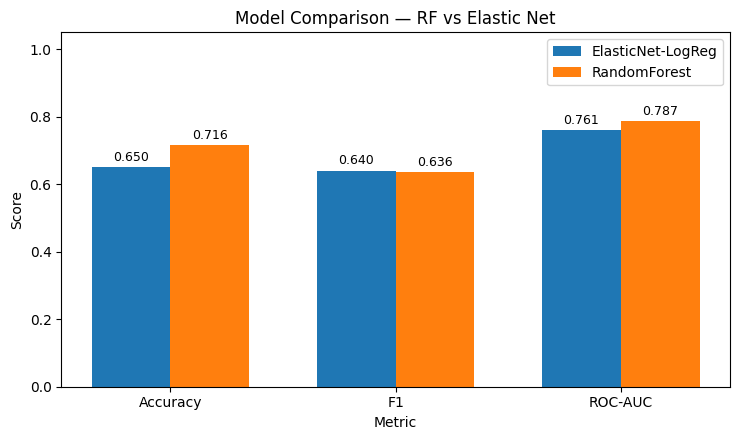

In [45]:
# --- Step 9B: Bar chart comparison (Accuracy, F1, ROC-AUC) ---

import matplotlib.pyplot as plt
metrics = ["accuracy","f1","roc_auc"]

fig = plt.figure(figsize=(7.5, 4.5))
x = np.arange(len(metrics))
width = 0.35

vals_en = summary_df.loc["ElasticNet-LogReg", metrics].values.astype(float)
vals_rf = summary_df.loc["RandomForest", metrics].values.astype(float)

plt.bar(x - width/2, vals_en, width, label="ElasticNet-LogReg")
plt.bar(x + width/2, vals_rf, width, label="RandomForest")

for i, v in enumerate(vals_en):
    plt.text(x[i]-width/2, v + 0.01, f"{v:.3f}", ha="center", va="bottom", fontsize=9)
for i, v in enumerate(vals_rf):
    plt.text(x[i]+width/2, v + 0.01, f"{v:.3f}", ha="center", va="bottom", fontsize=9)

plt.xticks(x, ["Accuracy","F1","ROC-AUC"])
plt.ylim(0, 1.05)
plt.title("Model Comparison — RF vs Elastic Net")
plt.legend()
plt.xlabel("Metric")
plt.ylabel("Score")
plt.tight_layout()
plt.show()


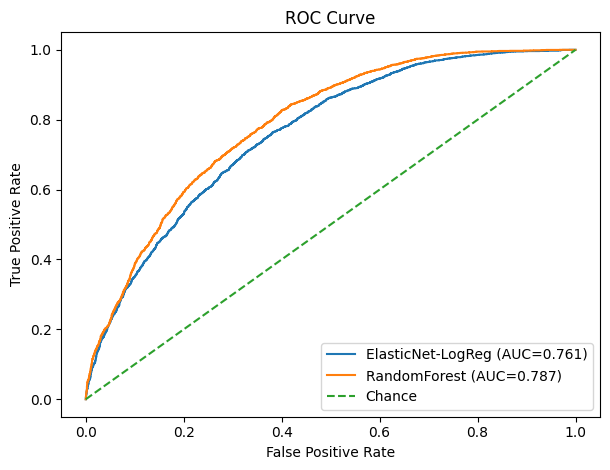

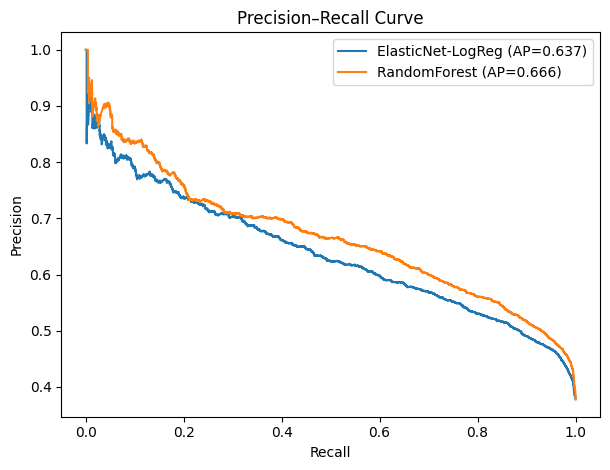

In [46]:
# --- Step 9C: ROC and Precision–Recall curves ---

from sklearn.metrics import roc_curve, precision_recall_curve

# ROC
fig = plt.figure(figsize=(6.2,4.8))
for name, proba in [("ElasticNet-LogReg", res_en["proba"]), ("RandomForest", res_rf["proba"])]:
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
plt.plot([0,1],[0,1], linestyle="--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

# Precision–Recall
fig = plt.figure(figsize=(6.2,4.8))
for name, proba in [("ElasticNet-LogReg", res_en["proba"]), ("RandomForest", res_rf["proba"])]:
    p, r, _ = precision_recall_curve(y_test, proba)
    ap = average_precision_score(y_test, proba)
    plt.plot(r, p, label=f"{name} (AP={ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.tight_layout()
plt.show()


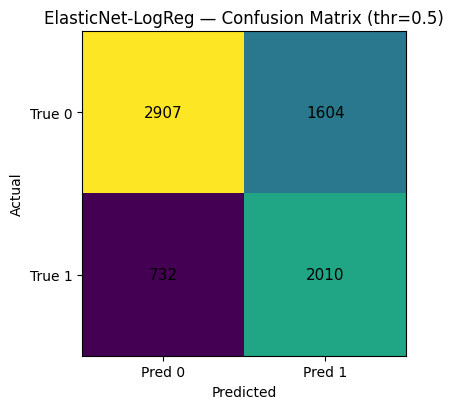

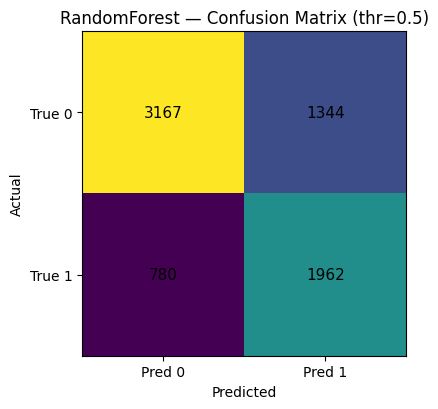

In [47]:
# --- Step 9D: Confusion matrices (threshold = 0.5) ---

from matplotlib import pyplot as plt

def plot_cm(cm, title):
    fig = plt.figure(figsize=(4.6,4.2))
    plt.imshow(cm, interpolation="nearest")
    for (i,j), v in np.ndenumerate(cm):
        plt.text(j, i, f"{v}", ha="center", va="center", fontsize=11)
    plt.xticks([0,1], ["Pred 0","Pred 1"])
    plt.yticks([0,1], ["True 0","True 1"])
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

cm_en = confusion_matrix(y_test, res_en["y_pred_05"])
cm_rf = confusion_matrix(y_test, res_rf["y_pred_05"])

plot_cm(cm_en, "ElasticNet-LogReg — Confusion Matrix (thr=0.5)")
plot_cm(cm_rf, "RandomForest — Confusion Matrix (thr=0.5)")
